# Milo - KNN based differential abundance analysis

This notebook demonstrates how to run differential abundance analysis on single-cell datasets using the [Milo framework](https://www.nature.com/articles/s41587-021-01033-z) {cite}`Dann2022`.

Many biological conditions (disease, development, genetic KOs) can induce shifts in cell composition, where cells of a given state become enriched or depleted in response to a perturbation. With differential abundance analysis, we quantify consistent changes in cell composition across replicate samples.
While differential abundance analysis can be performed on cell type clusters, it's not always possible or practical to use precisely labeled clusters, especially when we are interested in studying transitional states, such as during developmental processes, or when we expect only a subpopulation of a cell type to be affected by the condition of interest.
Milo is a method to detect compositional changes occurring in smaller subpopulations of cells, defined as neighbourhoods over the k-nearest neighbor (KNN) graph of cell-cell similarities.

In [ ]:
%load_ext autoreload
%autoreload 2

## Setup

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pertpy as pt
import scanpy as sc

plt.rcParams["figure.figsize"] = (7, 7)
import numpy as np

sc.settings.verbosity = 3

## Dataset

For this vignette we will use a dataset of blood cells from COVID-19 patients - the [Stephenson et al. 2021](https://www.nature.com/articles/s41591-021-01329-2) dataset.
The original dataset is available via [cellxgene](https://cellxgene.cziscience.com/collections/ddfad306-714d-4cc0-9985-d9072820c530).
Here cells were subsampled to have 500 cells per donor, and predicted doublets and low quality cells were filtered out. 

In [ ]:
adata = pt.data.stephenson_2021_subsampled()

In [ ]:
adata

AnnData object with n_obs × n_vars = 62509 × 16299
    obs: 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'
    uns: 'log1p', 'umap'
    obsm: 'X_scVI', 'X_umap'

This object collects data from PBMCs of 119 individuals (`adata.obs['patient_id']`), with varying severity of COVID-19 |(`adata.obs['Status_on_day_collection_summary']`). Samples were collected from three different hospitals (`adata.obs['Site']`). The dataset also includes 6 samples from PBMCs of healthy patients stimulated with LPS to simulate anti-viral response, which we will exclude in subsequent analysis.

In [ ]:
adata.obs["COVID_severity"] = adata.obs["Status_on_day_collection_summary"].copy()  # short name
adata.obs[["patient_id", "COVID_severity"]].drop_duplicates().value_counts("COVID_severity")

COVID_severity
Moderate        30
Healthy         23
Mild            23
Critical        15
Severe          13
Asymptomatic     9
LPS_10hours      3
LPS_90mins       3
dtype: int64

Here the data from different patients and sites has been integrated in a common latent space, minimizing the differences between donors, by mapping with [scArches](https://www.nature.com/articles/s41587-021-01001-7) using an [scVI](https://www.nature.com/articles/s41592-018-0229-2) model trained on healthy PBMCs (see [here](https://www.biorxiv.org/content/10.1101/2022.11.10.515939v1) for references on integration). We can visualize the batch-corrected space using UMAP.

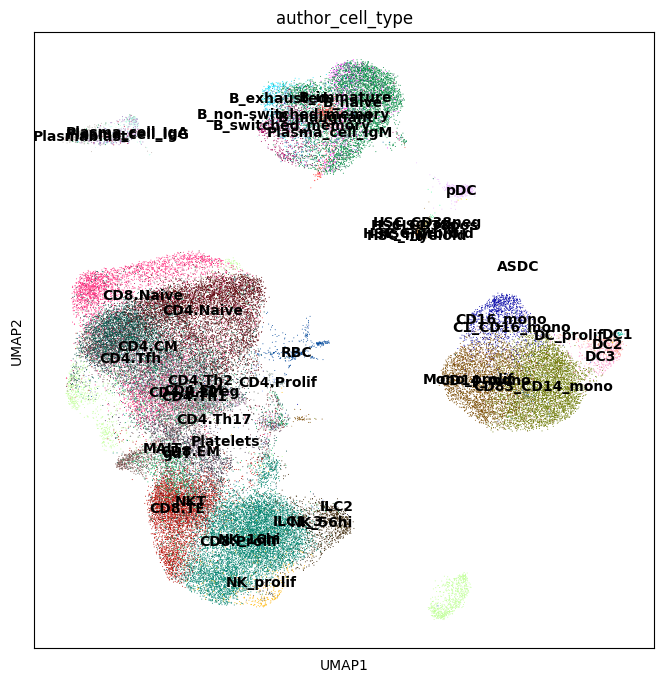

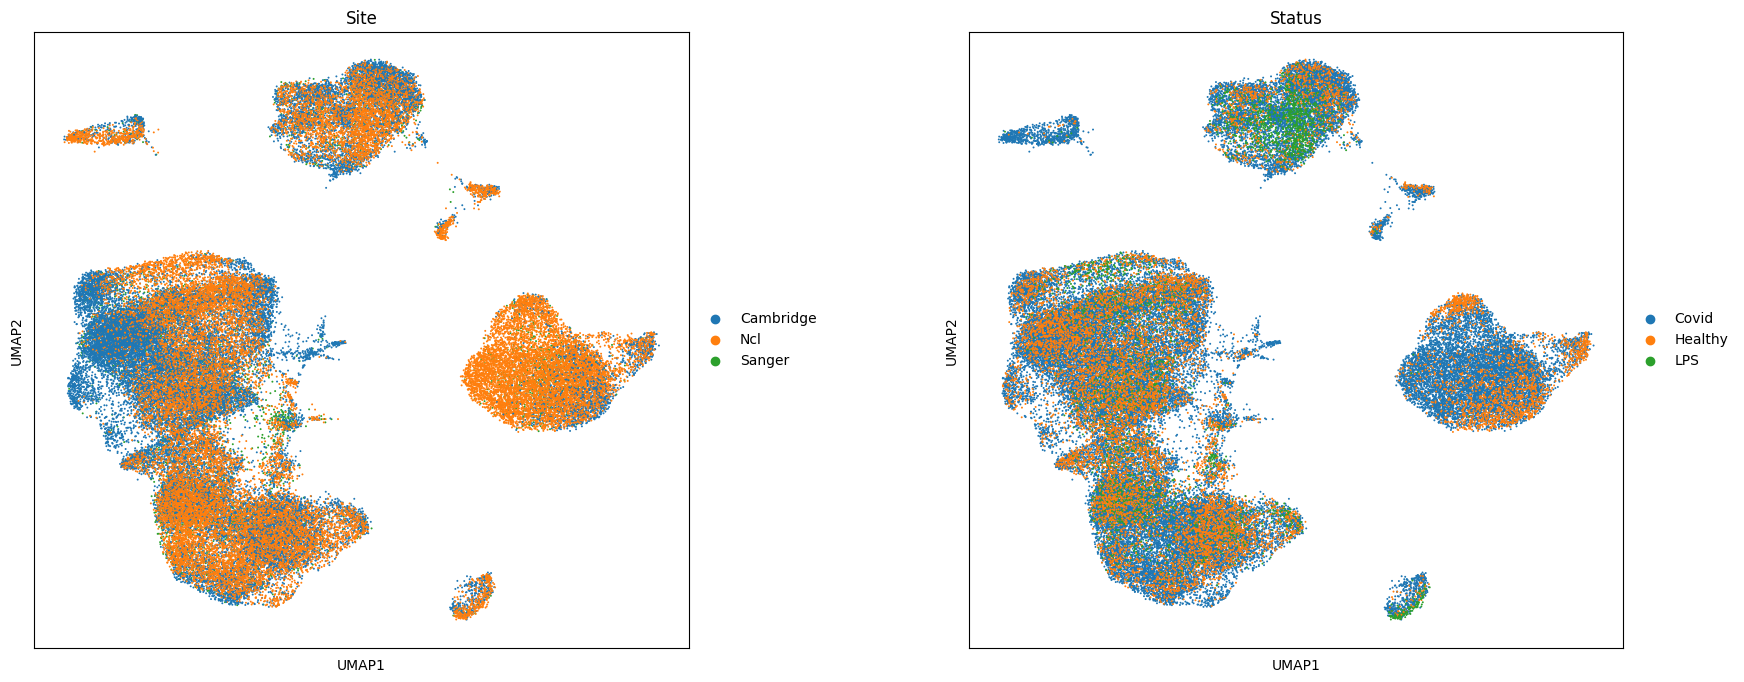

In [ ]:
sc.pl.umap(adata, color=["author_cell_type"], legend_loc="on data")
sc.pl.umap(adata, color=["Site", "Status"], wspace=0.3, size=8)

In this dataset we are interested in identifying cell populations that increase in abundance in response to COVID-19, and with varying degrees of severity COVID-19 severity.

### Prepare for Milo analysis

In [ ]:
## Exclude LPS samples
adata = adata[adata.obs["Status"] != "LPS"].copy()

## Initialize object for Milo analysis
milo = pt.tl.Milo()
mdata = milo.load(adata)

When initializing the Milo object, we create a [MuData](https://mudata.readthedocs.io/en/latest/notebooks/quickstart_mudata.html) object which will store both the gene expression matrices (`rna` view) and cell count matrices used for differential abundance analysis (`milo` view). 

In [ ]:
mdata

MuData object with n_obs × n_vars = 59873 × 16299
  2 modalities
    rna:	59873 x 16299
      obs:	'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group', 'COVID_severity'
      var:	'gene_id', 'gene_name'
      uns:	'log1p', 'umap', 'author_cell_type_colors', 'Site_colors', 'Status_colors', 'neighbors'
      obsm:	'X_scVI', 'X_umap'
      obsp:	'distances', 'connectivities'
    milo_compositional:	0 x 0

## Build KNN graph

We can use scanpy functions to build a KNN graph. We set the dimensionality and value for k to use in subsequent steps.

Here the value of k indicates the smallest possible size of neighbourhood in which we will quantify differential abundance (i.e. with k=50 the smallest neighbourhood will have 50 cells). Depending on the number of samples, you might want to use a high value of k for neighbourhood analysis, to have sufficient power to estimate abundance fold-changes. Since here we have data from > 100 patients, we set k=150 to have on average more than one cell per donor in each neighbourhood. 

In [ ]:
sc.pp.neighbors(mdata["rna"], use_rep="X_scVI", n_neighbors=150)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:14)


## Construct neighbourhoods

This step assigns cells to a set of representative neighbourhoods on the KNN graph. 

In [ ]:
milo.make_nhoods(mdata["rna"], prop=0.1)

The assignment of cells to neighbourhoods is stored as a sparse binary matrix in `mdata['rna'].obsm`. Here we see that cells have been assigned to 4307 neighbourhoods.

In [ ]:
mdata["rna"].obsm["nhoods"]

<59873x4307 sparse matrix of type '<class 'numpy.float32'>'
	with 1291378 stored elements in Compressed Sparse Row format>

The information on which cells are sampled as index cells of representative neighbourhoods is stored in `mdata['rna'].obs`, along with the distance of the index to the kth nearest neighbor, which is used later for the SpatialFDR correction.

In [ ]:
mdata["rna"][mdata["rna"].obs["nhood_ixs_refined"] != 0].obs[["nhood_ixs_refined", "nhood_kth_distance"]]

,nhood_ixs_refined,nhood_kth_distance
10_1038_s41591_021_01329_2-S12_CTGTGCTAGCTCCTCT-1,1,0.971554
10_1038_s41591_021_01329_2-S11_TAAGCGTAGATCGGGT-1,1,1.470572
10_1038_s41591_021_01329_2-S12_CTTCTCTAGGCAGGTT-1,1,0.824604
10_1038_s41591_021_01329_2-S11_ACGGAGACACCGAAAG-1,1,1.441965
10_1038_s41591_021_01329_2-S12_AACCATGGTCCATCCT-1,1,0.751696
...,...,...
10_1038_s41591_021_01329_2-GGGCATCGTGTCAATC-newcastle74,1,0.876956
10_1038_s41591_021_01329_2-TGCACCTGTCAAAGCG-newcastle74,1,1.203800
10_1038_s41591_021_01329_2-ATTTCTGCATGAAGTA-newcastle74,1,0.904092
10_1038_s41591_021_01329_2-GTCGTAATCTCGAGTA-newcastle74,1,1.094548


We can visualize the distribution of neighbourhood sizes, to check that the minimal value of k makes sense, and that the distribution of sizes is not too wide. 

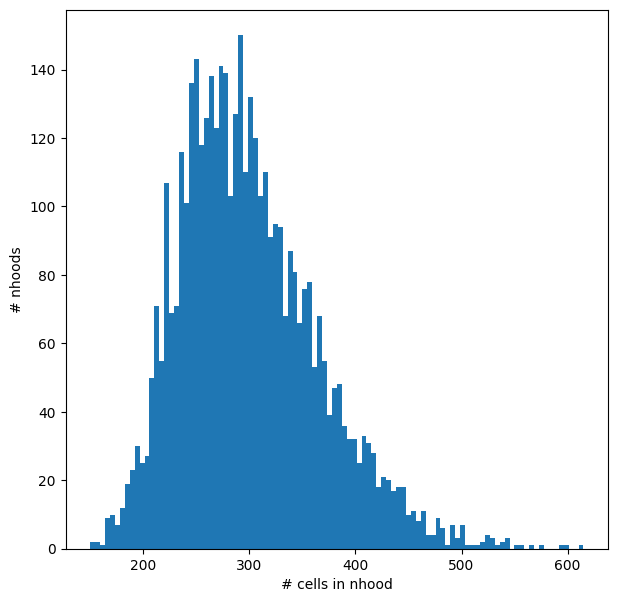

In [ ]:
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods");

## Count cells in neighbourhoods

Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. Therefore we have to count how many cells from each sample (in this case the patient) are in each neighbourhood. We need to use the cell metadata saved in `adata.obs` and specify which column contains the sample information.

In [ ]:
mdata = milo.count_nhoods(mdata, sample_col="patient_id")

This function populates the modality `milo` to mdata.  

mdata['milo'] is an anndata object where `obs` correspond to samples and `vars` correspond to neighbourhoods, and where `.X` stores the number of cells from each sample counted in a neighbourhood. This count matrix will be used for DA testing.

In [ ]:
mdata

MuData object with n_obs × n_vars = 59873 × 16299
  2 modalities
    rna:	59873 x 16299
      obs:	'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group', 'COVID_severity', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_id', 'gene_name'
      uns:	'log1p', 'umap', 'author_cell_type_colors', 'Site_colors', 'Status_colors', 'neighbors', 'nhood_neighbors_key'
      obsm:	'X_scVI', 'X_umap', 'nhoods'
      obsp:	'distances', 'connectivities'
    milo_compositional:	113 x 4307
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

In [ ]:
mdata["milo"]

AnnData object with n_obs × n_vars = 113 × 4307
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

## Differential abundance testing with GLM

We are now ready to test for differential abundance in time. The experimental design needs to be specified with [R-style formulas](https://genomicsclass.github.io/book/pages/expressing_design_formula.html). 

Here we run a simple comparison, testing for changes in cell abundance associated with COVID-19. 

In [ ]:
# Reorder categories
# (by default, the last category is taken as the condition of interest)
mdata["rna"].obs["Status"] = mdata["rna"].obs["Status"].cat.reorder_categories(["Healthy", "Covid"])
milo.da_nhoods(mdata, design="~Status")

We can explicitly specify the comparison we want to make using the parameter `model_contrasts`. This is especially important when we have more than two levels for a category and we want to compare against a specific control level.

In [ ]:
milo.da_nhoods(mdata, design="~Status", model_contrasts="StatusCovid-StatusHealthy")

In addition, we might want to take into account potential confounders that could affect cell abundances, for example batch effects. We can include confounders in the model using the syntax `~ confounders + condition`, where the covariate specified in the last term is always the covariate of interest. In this case we can estimate the effect of COVID-19 on cell abundance regressing out changes in cell abundance driven by the site of collection.

See below for more examples on how to specify different types of comparisons. 

In [ ]:
milo.da_nhoods(mdata, design="~Site+Status", model_contrasts="StatusCovid")

Information about the sample design is stored in `mdata['milo'].obs`:

In [ ]:
mdata["milo"].obs

,Status,Site,patient_id
AP1,Covid,Sanger,AP1
AP2,Covid,Sanger,AP2
AP3,Covid,Sanger,AP3
AP4,Covid,Sanger,AP4
AP5,Covid,Sanger,AP5
...,...,...,...
newcastle21v2,Covid,Ncl,newcastle21v2
newcastle49,Covid,Ncl,newcastle49
newcastle59,Covid,Ncl,newcastle59
newcastle65,Healthy,Ncl,newcastle65


The differential abundance test results are stored in `milo_mdata['milo'].var`. In particular:

* `logFC`: stores the log-Fold Change in abundance (i.e. the slope of the linear model)
* `PValue` stores the p-value for the test
* `SpatialFDR` stores the p-values adjusted for multiple testing (accounting for overlap between neighbourhoods)

In [ ]:
mdata["milo"].var

,index_cell,kth_distance,SpatialFDR,Nhood_size,nhood_annotation,nhood_annotation_frac,logFC,logCPM,F,PValue,FDR
0,10_1038_s41591_021_01329_2-S12_CTGTGCTAGCTCCTCT-1,0.971554,0.754070,261.0,Mixed,0.367816,-0.232552,8.555860,0.410906,0.522339,0.737128
1,10_1038_s41591_021_01329_2-S11_TAAGCGTAGATCGGGT-1,1.470572,0.463495,255.0,Mixed,0.200000,-0.548279,8.563358,1.619824,0.204785,0.439248
2,10_1038_s41591_021_01329_2-S12_CTTCTCTAGGCAGGTT-1,0.824604,0.971190,287.0,CD4.CM,0.634146,-0.037593,8.600876,0.010044,0.920285,0.967389
3,10_1038_s41591_021_01329_2-S11_ACGGAGACACCGAAAG-1,1.441965,0.424277,225.0,Mixed,0.351111,0.572683,8.451508,1.829268,0.177939,0.400619
4,10_1038_s41591_021_01329_2-S12_AACCATGGTCCATCCT-1,0.751696,0.996721,216.0,Mixed,0.472222,-0.009325,8.396741,0.000068,0.993406,0.996414
...,...,...,...,...,...,...,...,...,...,...,...
4302,10_1038_s41591_021_01329_2-GGGCATCGTGTCAATC-ne...,0.876956,0.045042,338.0,CD83_CD14_mono,0.961538,-1.158965,8.726121,7.728468,0.006024,0.038664
4303,10_1038_s41591_021_01329_2-TGCACCTGTCAAAGCG-ne...,1.203800,0.086444,237.0,CD8.EM,0.687764,-0.944625,8.514239,5.963366,0.015589,0.075946
4304,10_1038_s41591_021_01329_2-ATTTCTGCATGAAGTA-ne...,0.904092,0.433902,250.0,CD8.TE,0.780000,-0.582428,8.531476,1.777272,0.184198,0.410207
4305,10_1038_s41591_021_01329_2-GTCGTAATCTCGAGTA-ne...,1.094548,0.392866,276.0,Mixed,0.532609,0.586302,8.618117,2.023270,0.156665,0.370135


We can start inspecting the results of our DA analysis from a couple of standard diagnostic plots. 

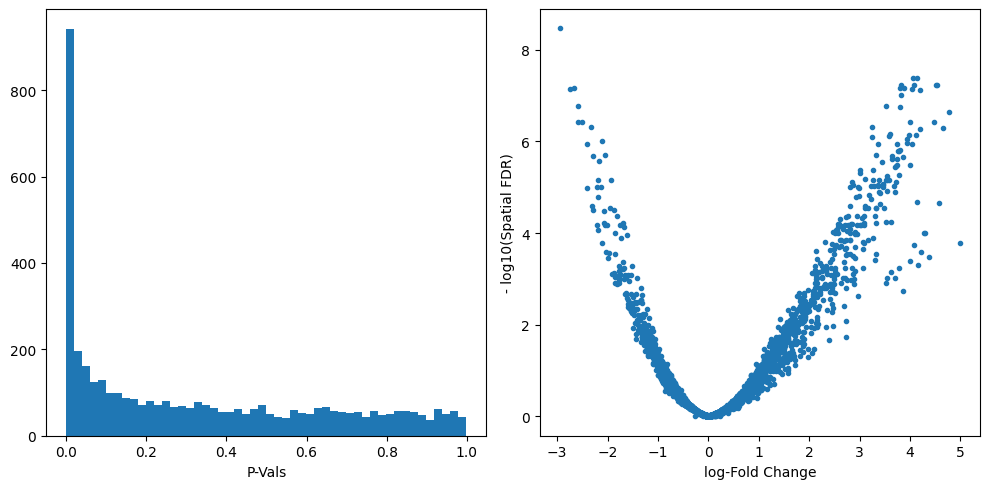

In [ ]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10, 5]
plt.subplot(1, 2, 1)
plt.hist(mdata["milo"].var.PValue, bins=50)
plt.xlabel("P-Vals")
plt.subplot(1, 2, 2)
plt.plot(mdata["milo"].var.logFC, -np.log10(mdata["milo"].var.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

## Visualize results on embedding

To visualize DA results relating them to the embedding of single cells, we can build an abstracted graph of neighbourhoods that we can superimpose on the single-cell embedding. Here each node represents a neighbourhood, and the layout of nodes is determined by the position of the index cell in the UMAP embedding of all single-cells. The neighbourhoods displaying singificant DA are colored by their log-Fold Change.

In [ ]:
milo.build_nhood_graph(mdata)

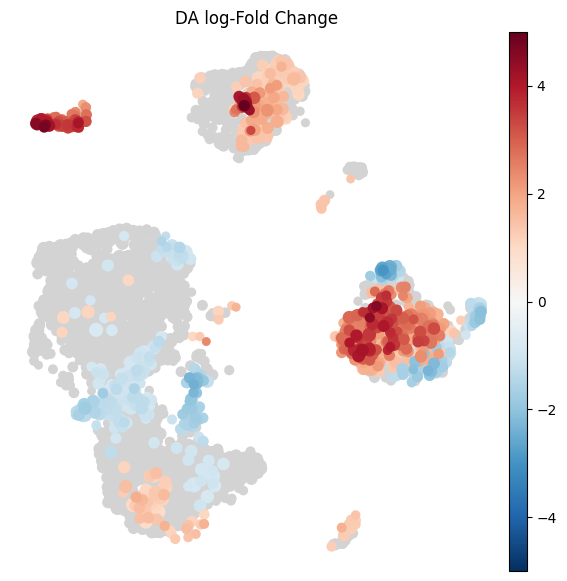

In [ ]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  ## SpatialFDR level (1%)
    min_size=1,  ## Size of smallest dot
)

## Visualize result by celltype

We might want to visualize whether DA is particularly evident in certain cell types. To do this, we assign a cell type label to each neighbourhood by finding the most abundant cell type within cells in each neighbourhood (after all, neighbourhoods are in most cases small subpopulations within the same cell type). We can label neighbourhoods in the results data.frame using the function `milo.annotate_nhoods`. This also saves the fraction of cells harbouring the label.

In [ ]:
milo.annotate_nhoods(mdata, anno_col="author_cell_type")

We can see that for the majority of neighbourhoods, almost all cells have the same cell type label. We can rename neighbourhoods where less than 60% of the cells have the top label as "Mixed"

Text(0.5, 0, 'celltype fraction')

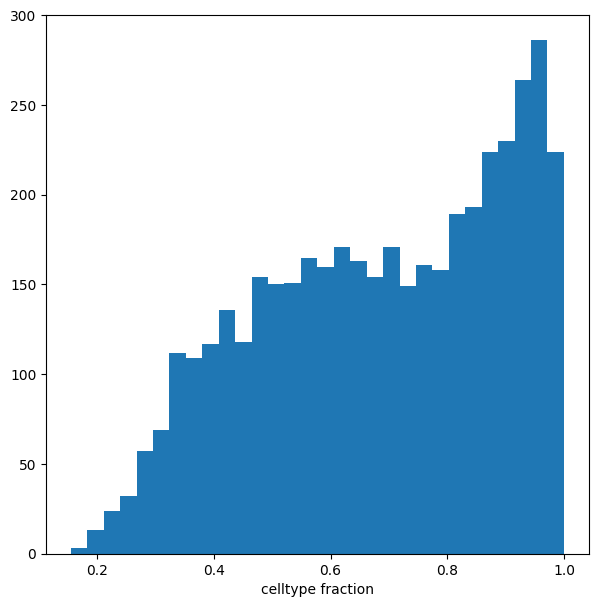

In [ ]:
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [ ]:
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

Now we can visualize the fold changes by cell type annotation.

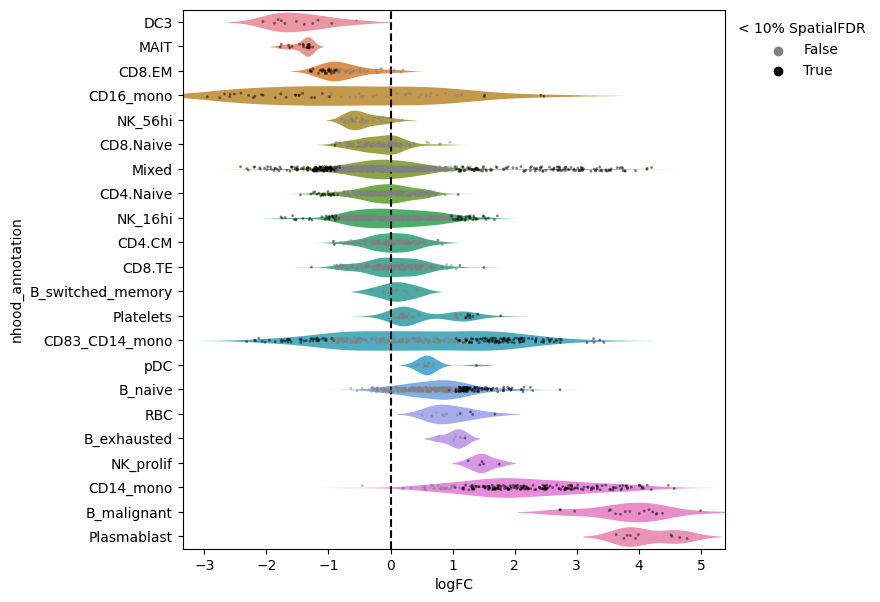

In [ ]:
milo.plot_da_beeswarm(mdata, alpha=0.1)

This shows that neighbourhoods of Plasmablast cells, malignant B cells and monocytes are especially enriched in cells from COVID-19 samples.

We can check the effect size by visualizing the cell counts directly

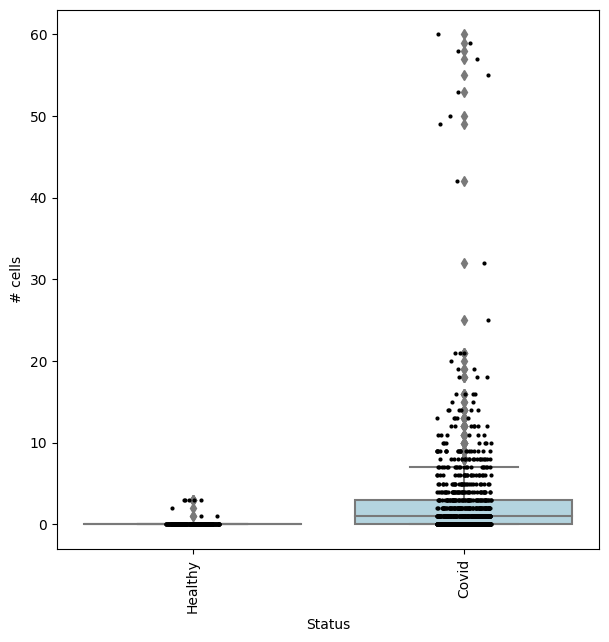

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "Plasmablast")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="Status", subset_nhoods=pl_nhoods, log_counts=False)

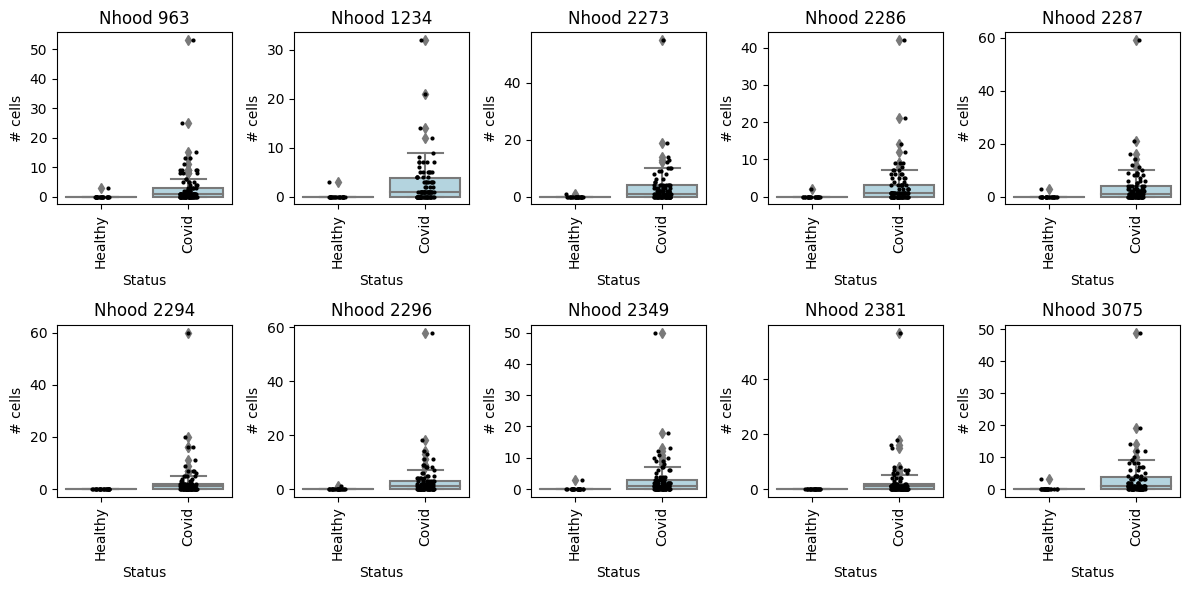

In [ ]:
## or one neighbourhood at a time
with matplotlib.rc_context({"figure.figsize": [12, 6]}):
    for i, nh in enumerate(pl_nhoods):
        plt.subplot(2, 5, i + 1)
        milo.plot_nhood_counts_by_cond(mdata, test_var="Status", subset_nhoods=nh, log_counts=False)
        plt.title(f"Nhood {nh}")
    plt.tight_layout()

## Specifying DA comparisons - examples using model contrasts

We can compute fold-changes and p-values for multiple comparisons on the same set of neighbourhoods, by specifying the test of interest in the `design` and `model_contrasts` parameter.

For example, we can find neighbourhoods enriched in cells from Asymptomatic patients, compared to healthy individuals:

In [ ]:
severity_order = ["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]
mdata["rna"].obs["COVID_severity"] = mdata["rna"].obs["COVID_severity"].cat.reorder_categories(severity_order)

In [ ]:
milo.da_nhoods(mdata, design="~Site+COVID_severity", model_contrasts="COVID_severityAsymptomatic")
# no need to set "-COVID_severityHealthy", since this is the reference level

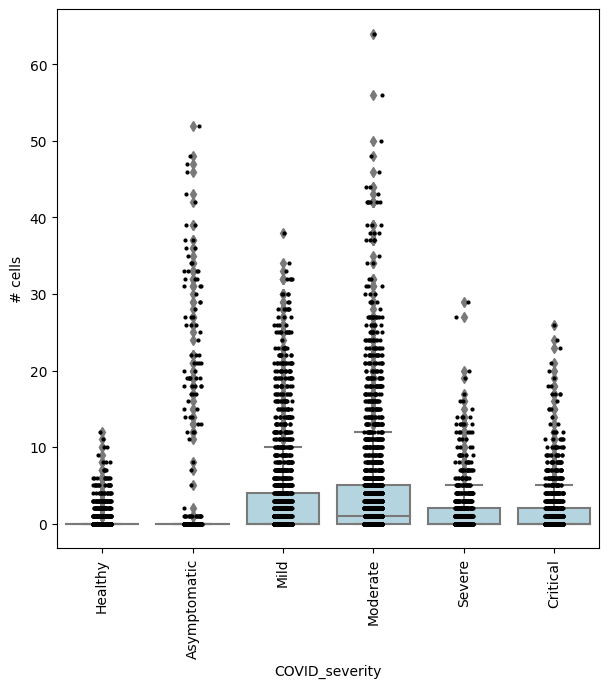

In [ ]:
## Get IDs of enriched neighbourhoods
pl_nhoods = mdata["milo"].var_names[(mdata["milo"].var["SpatialFDR"] < 0.01) & (mdata["milo"].var["logFC"] > 2)]

## Visualize cell counts by condition (x-axis) and individuals on all signif neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="COVID_severity", subset_nhoods=pl_nhoods, log_counts=False)

or comparing Asymptomatic patients againsts all other COVID-19 patients:

In [ ]:
milo.da_nhoods(
    mdata,
    design="~Site+COVID_severity",
    model_contrasts="COVID_severityAsymptomatic-(COVID_severityMild + COVID_severityModerate + COVID_severitySevere + COVID_severityCritical)",
)

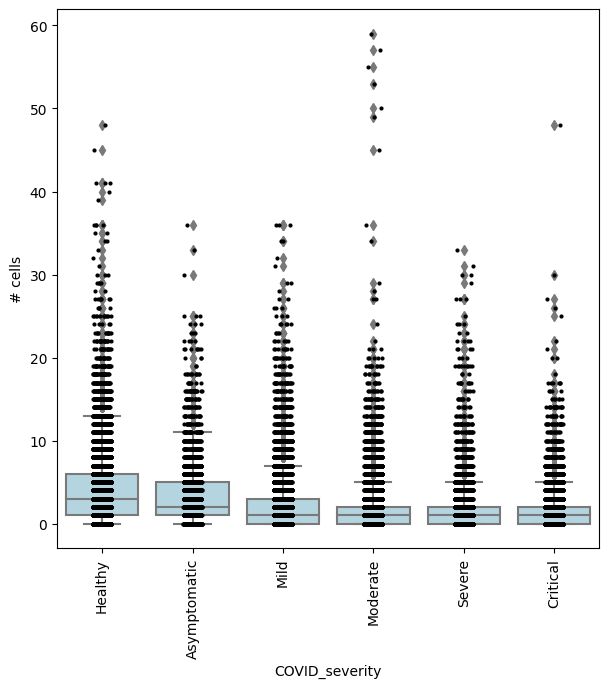

In [ ]:
## Get IDs of enriched neighbourhoods
pl_nhoods = mdata["milo"].var_names[(mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["logFC"] > 2)]

## Visualize cell counts by condition (x-axis) and individuals on all signif neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="COVID_severity", subset_nhoods=pl_nhoods, log_counts=False)

In this case, we could also be interested in finding where cell abundance increases or decreases linearly with COVID-19 severity. To do this, we need to encode COVID severity as a continuous variable

In [ ]:
severity_order = ["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]
mdata["rna"].obs["COVID_severity_continuous"] = mdata["rna"].obs["COVID_severity"].cat.codes

In [ ]:
milo.da_nhoods(mdata, design="~Site+COVID_severity_continuous")

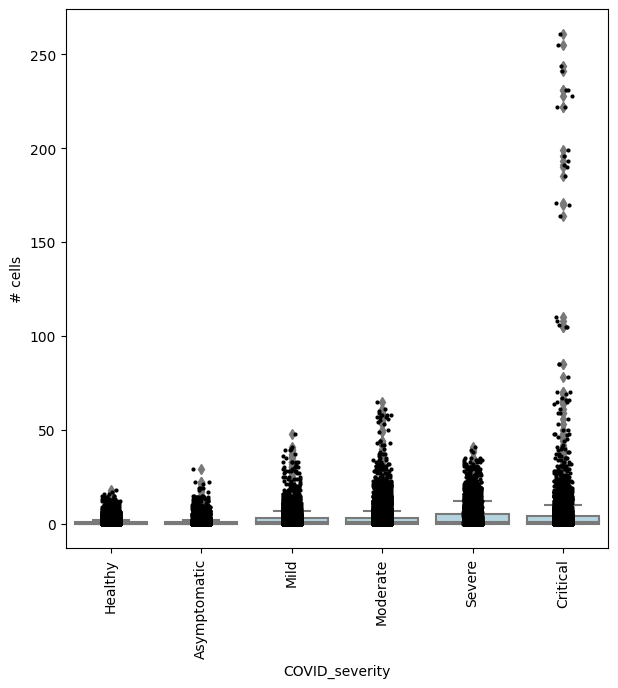

In [ ]:
## Get IDs of enriched neighbourhoods
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["logFC"] > 0)
]  ## notice how here logFCs are much smaller

## Add COVID severity labels to mdata['milo'].obs
milo.add_covariate_to_nhoods_var(mdata, ["COVID_severity"])
mdata["milo"].obs["COVID_severity"] = (
    mdata["milo"].obs["COVID_severity"].astype("category").cat.reorder_categories(severity_order)
)

## Visualize cell counts by condition (x-axis) and individuals on all signif neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="COVID_severity", subset_nhoods=pl_nhoods, log_counts=False)

## Conclusion

Milo is a computational framework designed for differential abundance analysis in single-cell datasets, enabling the detection of subtle compositional changes in cell populations by analyzing neighborhoods in a k-nearest neighbor graph of cell-cell similarities, particularly useful in scenarios where cell type clusters are imprecise or transitional states are of interest.

## References

1. Dann, E., Henderson, N.C., Teichmann, S.A. et al. Differential abundance testing on single-cell data using k-nearest neighbor graphs. Nat Biotechnol 40, 245–253 (2022). https://doi.org/10.1038/s41587-021-01033-z
2. Stephenson, E., Reynolds, G., Botting, R.A. et al. Single-cell multi-omics analysis of the immune response in COVID-19. Nat Med 27, 904–916 (2021). https://doi.org/10.1038/s41591-021-01329-2